In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utils import LOG_DIR, IBEX_LOG_DIR, PAPER_LOG_DIR, PAPER_IBEX_LOG_DIR

FIG_DIR = './figs'

def read_data(log_path, paper: bool = False):
    function_values = []
    with open(log_path, 'r') as file:
        for line in file:
            # Split the line into function value and coordinates, then extract the function value
            if not paper:
                func_val = line.split('],')[0].strip()
                func_val = func_val.replace('[', '').replace(']', '')
            else:
                func_val = line.split(', [')[0].strip()
                func_val = func_val.replace('[', '').replace(']', '')
            function_values.append(float(func_val))
    return -np.array(function_values)

def plot_trend(log_name, function_values):
    plt.plot(np.minimum.accumulate(function_values))

    plt.title(log_name)
    plt.xlabel('Iterations')
    plt.ylabel('Function Value')

    # plt.savefig(os.path.join(LOG_DIR, f"{log_name}_plot.png"))

def args_to_dir(paper: False, num_evals: int):
    if not paper and num_evals <= 1000:
        return LOG_DIR
    elif not paper and num_evals > 1000:
        return IBEX_LOG_DIR
    elif paper and num_evals <= 1000:
        return PAPER_LOG_DIR
    elif paper and num_evals > 1000:
        return PAPER_IBEX_LOG_DIR

def args_to_expr_path(implem: str, func_name: str, dimension: int, num_evals:int, paper: bool = False):
    expr_dir = args_to_dir(paper, num_evals)
    if not paper:
        # implem can either be 'mcts' or 'turbo'
        bench_name = func_name + str(dimension) + 'd'
        expr_data_path = f"{implem}_{bench_name}_{num_evals}_data.log"
    else:
        expr_data_path = f'{func_name}_{dimension}_{num_evals}_turbo_data.log'
    return os.path.join(expr_dir, expr_data_path)

def args_to_exprname(implem: str, func_name: str, dimension: int, num_evals:int, paper: bool = False):
    return f'{implem}_{func_name}_{dimension}_{num_evals}{"_paper" if paper else ""}'

def plot_from_args(args):
    function_values = read_data(args_to_expr_path(**args), args['paper'])
    plot_trend(args_to_exprname(**args), function_values)

def check_arg_list(args_list):
    # check whether args['func_name'] and args['dimension'] are the same
    # if not, then we cannot plot them together
    func_name = args_list[0]['func_name']
    dimension = args_list[0]['dimension']
    for args in args_list:
        if args['func_name'] != func_name or args['dimension'] != dimension:
            raise ValueError('Cannot plot different functions together')

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
def plot_from_args_list(args_list, log_y: bool = False, save_fig: bool = False):
    check_arg_list(args_list)
    
    figure = plt.figure(figsize=(8, 6))
    for i, args in enumerate(args_list):
        function_values = read_data(args_to_expr_path(**args), args['paper'])
        color = colors[i]
        label = f'{args["implem"]} ({"original" if args["paper"] else "self-implemented"})'

        if log_y:
            plt.semilogy(np.minimum.accumulate(function_values), color=color, label=label)
        else:
            plt.plot(np.minimum.accumulate(function_values), color=color, label=label)

    plt.title(f'{args["func_name"]} ({args["dimension"]}D)')
    plt.ylabel('Function Value')
    plt.xlabel('Number of Samples')
    plt.legend()

    plt.savefig(os.path.join(FIG_DIR, f'{args["func_name"]}_{args["dimension"]}D.pdf'))
    plt.show()
    

def build_args_list(func_name: str, dimension: int, num_evals: int):
    return [
        {
            'implem': 'mcts',
            'func_name': func_name,
            'dimension': dimension,
            'num_evals': num_evals,
            'paper': False
        }, {
            'implem': 'turbo',
            'func_name': func_name,
            'dimension': dimension,
            'num_evals': num_evals,
            'paper': False
        }, {
            'implem': 'mcts',
            'func_name': func_name,
            'dimension': dimension,
            'num_evals': num_evals,
            'paper': True
        },
    ]


### Ackley

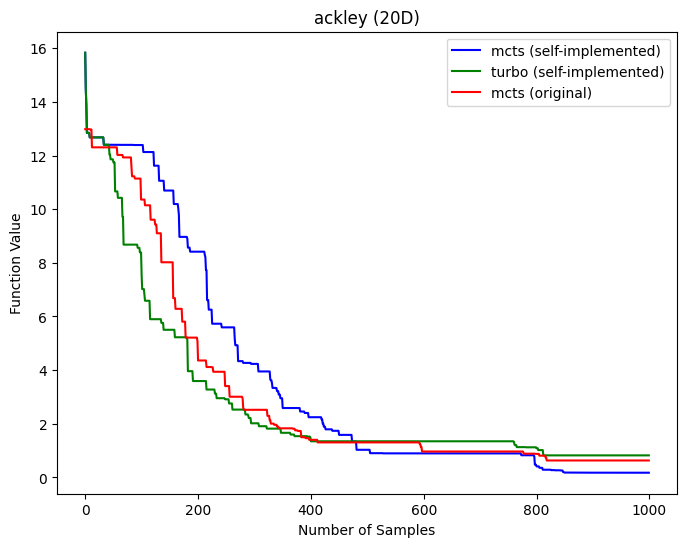

In [2]:
ackley_20_args = build_args_list('ackley', 20, 1000)
plot_from_args_list(ackley_20_args)

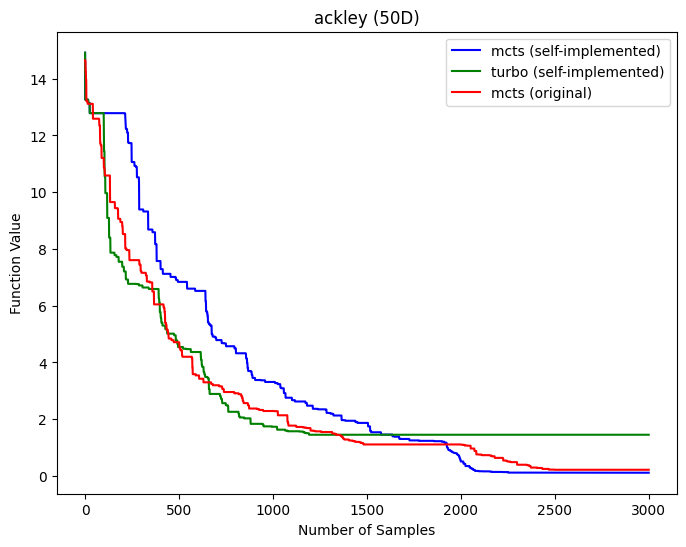

In [66]:
ackley_50_args = build_args_list('ackley', 50, 3000)
plot_from_args_list(ackley_50_args)


### Levy

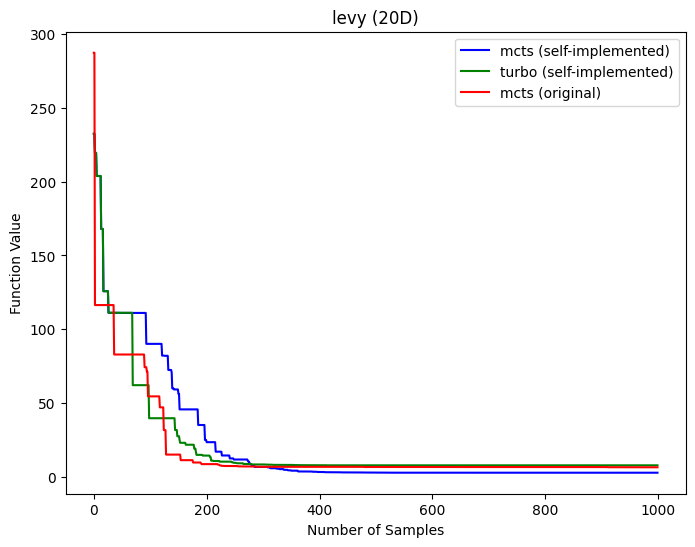

In [67]:
levy_20_args = build_args_list('levy', 20, 1000)   
plot_from_args_list(levy_20_args)


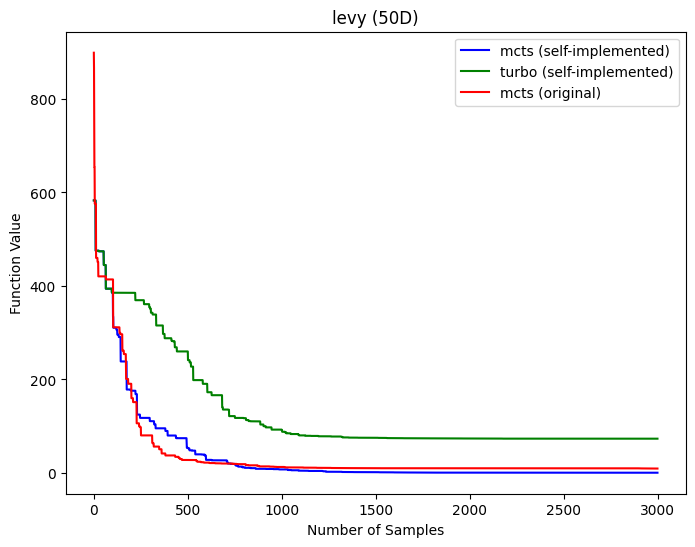

In [68]:
levy_50_args = build_args_list('levy', 50, 3000)   
plot_from_args_list(levy_50_args)


### Rastrigin

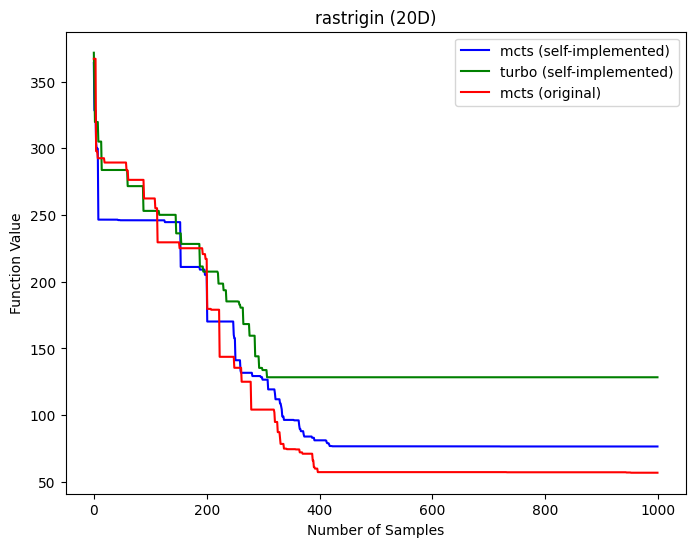

In [69]:
rastrigin_20_args = build_args_list('rastrigin', 20, 1000)   
plot_from_args_list(rastrigin_20_args)


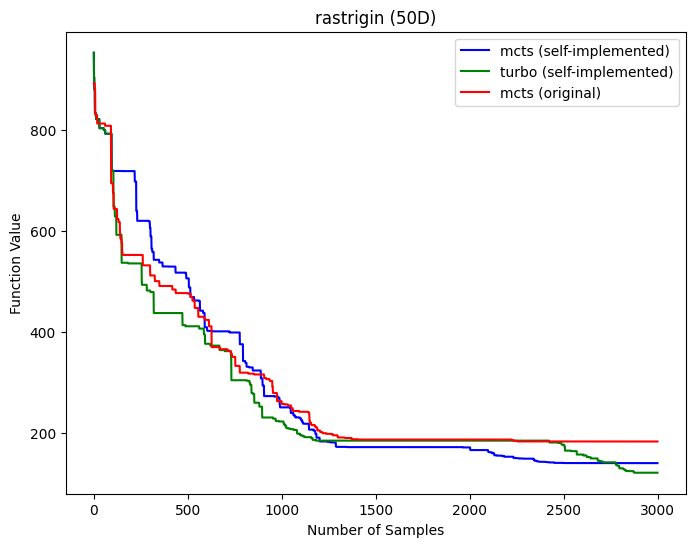

In [70]:
rastrigin_50_args = build_args_list('rastrigin', 50, 3000)   
plot_from_args_list(rastrigin_50_args)


### Rosenbrock

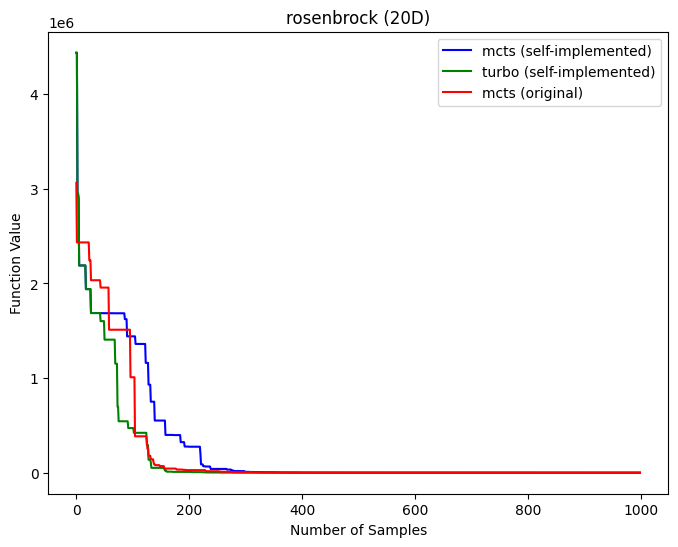

In [2]:
rosenbrock_20_args = build_args_list('rosenbrock', 20, 1000)   
plot_from_args_list(rosenbrock_20_args)


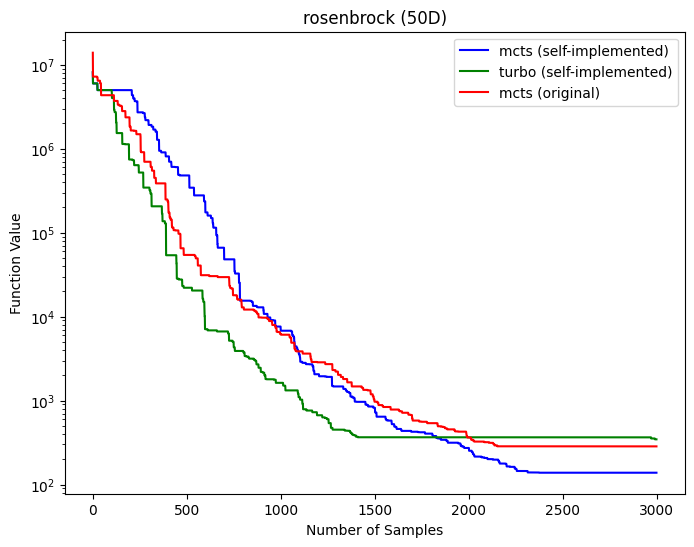

In [3]:
rosenbrock_50_args = build_args_list('rosenbrock', 50, 3000)   
plot_from_args_list(rosenbrock_50_args, log_y=True)

## Efficiency

In [38]:
import numpy as np
import pandas as pd

# Timing data obtained from running logs (in seconds)
data = {
    "Ackley": {
        "20D": [161.37, 267.171],
        "50D": [607.61, 3144.83]
    },
    "Levy": {
        "20D": [168.45, 215.346],
        "50D": [998.39, 1941.49]
    },
    "Rosenbrock": {
        "20D": [192.27, 384.58],
        "50D": [833.53, 2774.05]
    },
    "Rastrigin": {
        "20D": [274.58, 315.35],
        "50D": [1228.04, 4253.50]
    }
}

# Converting data to numpy arrays
data_arrays = {func: {dim: np.array(times) for dim, times in dims.items()} for func, dims in data.items()}

# Calculating speed-up rates
speed_ups = {func: {dim: round(times[1] / times[0], 3) for dim, times in dims.items()} for func, dims in data_arrays.items()}

# Creating a DataFrame for a tabular view
speed_ups_df = pd.DataFrame(speed_ups).T  # Transpose to get functions as rows
speed_ups_df.columns.name = "Function / Dimension"
speed_ups_df.index.name = "Function"
speed_ups_df


Function / Dimension,20D,50D
Function,,
Ackley,1.656,5.176
Levy,1.278,1.945
Rosenbrock,2.000,3.328
Rastrigin,1.148,3.464
